# Image Extrusion Blending
The goal is to blend an image into a background image and extrude the edges in the foreground image to make it visible after matching colors 1:1 with the background image.

Resources: 
* https://www.meccanismocomplesso.org/en/opencv-python-edge-detection-and-image-gradient-analysis/https://www.meccanismocomplesso.org/en/opencv-python-edge-detection-and-image-gradient-analysis/

In [1]:
!pip -q install opencv-contrib-python Pillow matplotlib numpy tk

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


## Edge Detection and Image Gradient Analysis
See: https://www.meccanismocomplesso.org/en/opencv-python-edge-detection-and-image-gradient-analysis/

In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import color_transfer as ct
import json

In [3]:
%matplotlib inline

In [4]:
%%sh
ls *jpeg

blackandwhite.jpeg
gradient.jpeg
logos.jpeg


In [5]:
def display(img, title="Image", cmap="gray", figsize=(10,5)):
  plt.figure(figsize=figsize)
  plt.grid(False)
  plt.axis('off')
  plt.imshow(img, cmap=cmap)
  plt.title(title), plt.xticks([]), plt.yticks([])
  plt.show()

In [6]:
def display_all(images: list, column_limit=2, cmap="gray", figsize=(10,5)) -> None:
  rows = 1
  cols = len(images)
  
  if cols > column_limit:
    rows = int(cols / column_limit) + 1
    cols = column_limit
    
  # Corner case check to ensure there's enough rows
  if (rows * cols) < len(images):
    rows += 1
  
  plt.figure(figsize=figsize)
  
  for entry, i in zip(images, range(len(images))):
    if "img" in entry:
      img = entry["img"]
      title = f"Image {i+1}" if "title" not in entry else entry["title"]
      
      plt.subplot(rows, cols, i+1)
      plt.imshow(img, cmap=cmap)
      plt.title(title)
      plt.xticks([]), plt.yticks([])
    
  plt.show()
    

In [7]:
def display_filter_results(img, laplacian, sobel_x, sobel_y, figsize=(10,5)):
  rows = 2
  cols = 2
  
  plt.figure(figsize=figsize)

  plt.subplot(rows, cols, 1), plt.imshow(img,cmap = 'gray')
  plt.title('Original (Grayscale)'), plt.xticks([]), plt.yticks([])
  plt.subplot(rows, cols, 2), plt.imshow(laplacian,cmap = 'gray')
  plt.title('Laplacian'), plt.xticks([]), plt.yticks([])
  plt.subplot(rows, cols, 3), plt.imshow(sobel_x,cmap = 'gray')
  plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
  plt.subplot(rows, cols, 4), plt.imshow(sobel_y,cmap = 'gray')
  plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])

  plt.show()

In [8]:
def display_sobel_xy(sobel_x, sobel_y, figsize=(10,5)):
  rows = 1
  cols = 2
  
  plt.figure(figsize=figsize)

  plt.subplot(rows, cols, 1), plt.imshow(sobel_x,cmap = 'gray')
  plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
  plt.subplot(rows, cols, 2), plt.imshow(sobel_y,cmap = 'gray')
  plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])

  plt.show()

In [9]:
def save_img(img, fname="image.png", cmap="gray", fmt="png"):
  plt.imsave(fname=fname, arr=img, cmap=cmap, format=fmt)

In [10]:
def is_equal_sides(img: np.ndarray) -> bool:
  """
  Determine whether an image length and width are equal to each other.
  
  Args:
    img (np.ndarray): Image to check width and height from shape.
    
  Returns:
    bool: Whether the image sides are equal.
  """
  s = img.shape
  return s[0] == s[1]

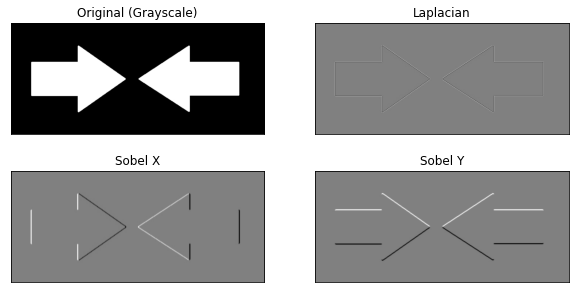

In [11]:
# Read black and white test image and use laplacian and sobel algorithms to find edges
img = cv2.imread('blackandwhite.jpeg', 0)

laplacian = cv2.Laplacian(img, cv2.CV_64F)
sobel_x = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)
sobel_y = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)

display_filter_results(img, laplacian, sobel_x, sobel_y)

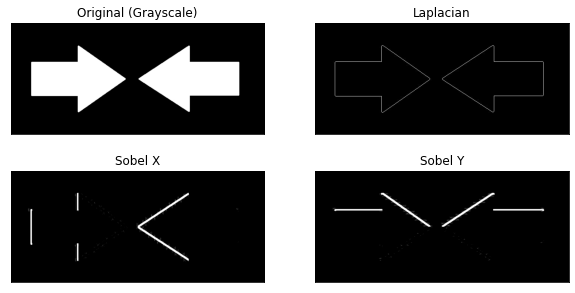

In [12]:
# Change the type of output data from cv2.CV_64F to cv2.CV_8U in the filters function of the previous results
# to detect edges better
laplacian = cv2.Laplacian(img, cv2.CV_8U)
sobel_x = cv2.Sobel(img,cv2.CV_8U,1,0,ksize=5)
sobel_y = cv2.Sobel(img,cv2.CV_8U,0,1,ksize=5)

display_filter_results(img, laplacian, sobel_x, sobel_y)

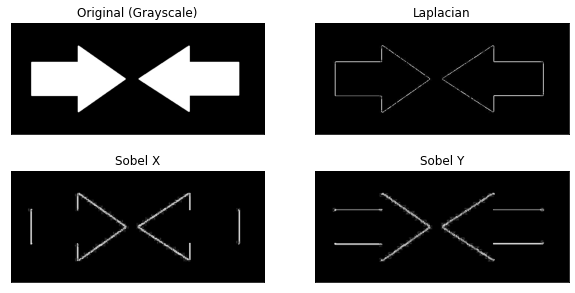

In [13]:
# Fix up previous results missing edges by negative slopes being set to 0 resulting in lost edges during transformation
# To mitigate this issue, keep the data in the output of the filter in cv2.CV_64F (instead of cv2.CV_8U), 
# then calculate the absolute value, and finally do the conversion in cv2.CV_8U.
laplacian64 = cv2.Laplacian(img, cv2.CV_64F)
sobel_x64 = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)
sobel_y64 = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)

laplacian = np.uint8(np.absolute(laplacian64))
sobel_x = np.uint8(np.absolute(sobel_x64))
sobel_y = np.uint8(np.absolute(sobel_y64))

display_filter_results(img, laplacian, sobel_x, sobel_y)

### Test Baseline Laplacian & Sobel Edge Detection on Sample Images

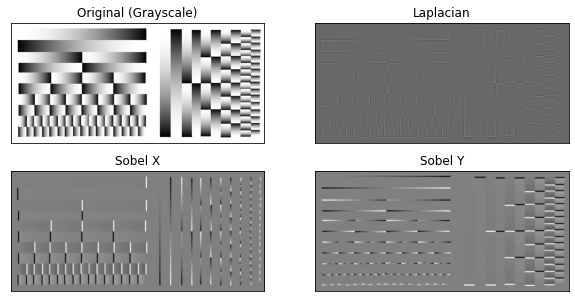

In [14]:
# Read black and white test image and use laplacian and sobel algorithms to find edges
img = cv2.imread('gradient.jpeg', 0)

laplacian = cv2.Laplacian(img, cv2.CV_64F)
sobel_x = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)
sobel_y = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)

display_filter_results(img, laplacian, sobel_x, sobel_y)

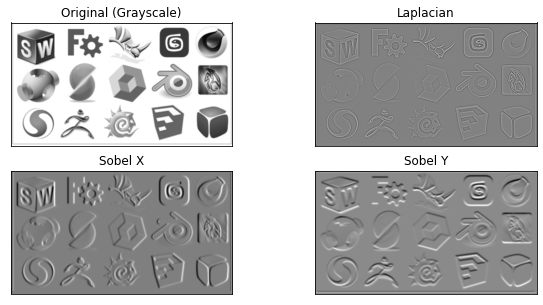

In [15]:
# Read black and white test image and use laplacian and sobel algorithms to find edges
img = cv2.imread('logos.jpeg', 0)

laplacian = cv2.Laplacian(img, cv2.CV_64F)
sobel_x = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)
sobel_y = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)

display_filter_results(img, laplacian, sobel_x, sobel_y)

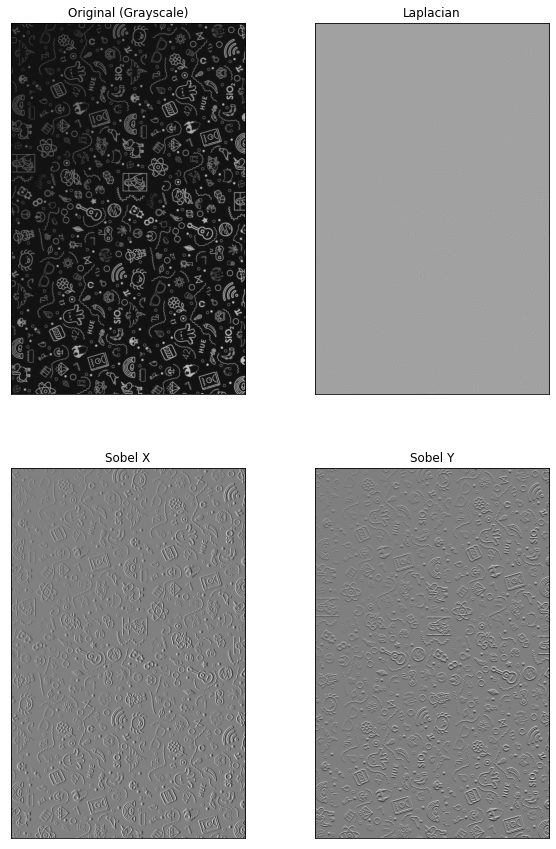

In [16]:
# Read black and white test image and use laplacian and sobel algorithms to find edges
img = cv2.imread('test-foreground.png', 0)

laplacian = cv2.Laplacian(img, cv2.CV_64F)
sobel_x = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=7)
sobel_y = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=7)

display_filter_results(img, laplacian, sobel_x, sobel_y, figsize=(10,15))

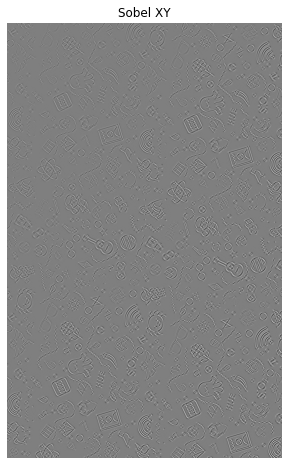

In [17]:
# Test sobel x and y combined
sobel_xy = cv2.Sobel(img,cv2.CV_64F,1,1,ksize=7)
display(sobel_xy, "Sobel XY", figsize=(8,8))

## Combine Background & Foreground Images using Color Transfer
Apply Laplacian & Sorbel filters to foreground image and interlace background image coloring into the filtered foreground image (color transfer algorithm) to achieve final goal result

In [18]:
%%sh
ls *.png

blended.png
bw_extruded_fg_img.png
extruded_fg_img.png
gray-foreground-img.png
test-background.png
test-foreground-2.png
test-foreground.png


In [19]:
help(cv2.imread)

Help on built-in function imread:

imread(...)
    imread(filename[, flags]) -> retval
    .   @brief Loads an image from a file.
    .   
    .   @anchor imread
    .   
    .   The function imread loads an image from the specified file and returns it. If the image cannot be
    .   read (because of missing file, improper permissions, unsupported or invalid format), the function
    .   returns an empty matrix ( Mat::data==NULL ).
    .   
    .   Currently, the following file formats are supported:
    .   
    .   -   Windows bitmaps - \*.bmp, \*.dib (always supported)
    .   -   JPEG files - \*.jpeg, \*.jpg, \*.jpe (see the *Note* section)
    .   -   JPEG 2000 files - \*.jp2 (see the *Note* section)
    .   -   Portable Network Graphics - \*.png (see the *Note* section)
    .   -   WebP - \*.webp (see the *Note* section)
    .   -   Portable image format - \*.pbm, \*.pgm, \*.ppm \*.pxm, \*.pnm (always supported)
    .   -   PFM files - \*.pfm (see the *Note* section)
    .   -   

In [20]:
bg_img = cv2.imread('test-background.png')
fg_img = cv2.imread('test-foreground.png') # NOTE: Read as grayscale with cv2.IMREAD_GRAYSCALE as 2nd arg

In [21]:
print(f"Background image shape: {bg_img.shape}")
print(f"Foreground image shape: {fg_img.shape}")

Background image shape: (450, 380, 3)
Foreground image shape: (1710, 1080, 3)


In [22]:
# Convert foreground image to grayscale
gray_fg_img = cv2.cvtColor(fg_img, cv2.COLOR_BGR2GRAY)

In [23]:
help(cv2.Sobel)

Help on built-in function Sobel:

Sobel(...)
    Sobel(src, ddepth, dx, dy[, dst[, ksize[, scale[, delta[, borderType]]]]]) -> dst
    .   @brief Calculates the first, second, third, or mixed image derivatives using an extended Sobel operator.
    .   
    .   In all cases except one, the \f$\texttt{ksize} \times \texttt{ksize}\f$ separable kernel is used to
    .   calculate the derivative. When \f$\texttt{ksize = 1}\f$, the \f$3 \times 1\f$ or \f$1 \times 3\f$
    .   kernel is used (that is, no Gaussian smoothing is done). `ksize = 1` can only be used for the first
    .   or the second x- or y- derivatives.
    .   
    .   There is also the special value `ksize = #FILTER_SCHARR (-1)` that corresponds to the \f$3\times3\f$ Scharr
    .   filter that may give more accurate results than the \f$3\times3\f$ Sobel. The Scharr aperture is
    .   
    .   \f[\vecthreethree{-3}{0}{3}{-10}{0}{10}{-3}{0}{3}\f]
    .   
    .   for the x-derivative, or transposed for the y-derivative.
    . 

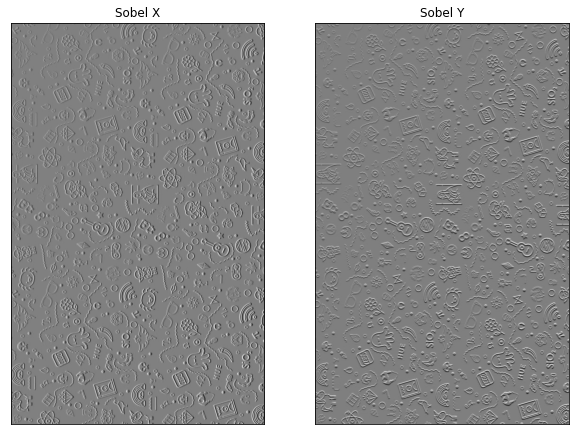

In [24]:
# Apply Laplacian & Sorbel filters to foreground image
fg_laplacian = cv2.Laplacian(gray_fg_img, cv2.CV_64F)
fg_sobel_x = cv2.Sobel(gray_fg_img,cv2.CV_64F,1,0,ksize=7)
fg_sobel_y = cv2.Sobel(gray_fg_img,cv2.CV_64F,0,1,ksize=7)

display_sobel_xy(fg_sobel_x, fg_sobel_y, figsize=(10,15))

In [25]:
# Select Sobel X results for remaining steps. Will let user deside once implemented as a standalone script
extruded_fg_img = fg_sobel_x

Foreground has equal sides? False
Minimum boundary: 380
Resizing foreground to match aspect ratio of background...
Background image size is (450, 380, 3)
Foreground image resized from (1710, 1080, 3) to (450, 380, 3)
Extruded foreground image resized from (1710, 1080) to (450, 380)


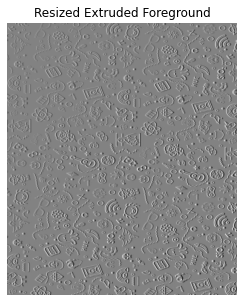

In [26]:
# Resize foreground image to match the size of the background image
# Add ability to add padding around foreground image when image 
# would be stretched to fit the size of the background image (e.g., when aspect ratios don't match)
equal_sides = is_equal_sides(fg_img)
print(f"Foreground has equal sides? {equal_sides}")

# Identify minimum bounds based on shape of background image
min_boundary = min(bg_img.shape[:2])
print(f"Minimum boundary: {min_boundary}")

original_fg_shape = fg_img.shape
original_extruded_fg_shape = extruded_fg_img.shape
h, w, c = bg_img.shape

# Determine if the foreground image has equal sides and process accordingly
# Need to maintain aspect ratio when resizing within minimum boundary (calculated in previous step)
if equal_sides:
  print("Resizing foreground with added padding...")
  n = int(min_boundary / 2) # New size
  
  # Calculate top and bottom padding
  h_padding = int((h-n)/2)
  top = h_padding
  bottom = h_padding
  
  # Calculate left and right padding
  w_padding = int((w-n)/2)
  left = w_padding
  right = w_padding
  
  # print(json.dumps({
  #   "n": n,
  #   "h": h,
  #   "w": w,
  #   "top": top,
  #   "bottom": bottom,
  #   "left": left,
  #   "right": right,
  # }, indent=2))
  
  fg_img = cv2.resize(fg_img, (n, n), interpolation=cv2.INTER_AREA)
  fg_img = cv2.copyMakeBorder(
    fg_img, 
    top, 
    bottom, 
    left, 
    right,
    cv2.BORDER_CONSTANT, 
    None, 
    value=(128, 128, 128)
  )
  
  extruded_fg_img = cv2.resize(extruded_fg_img, (n, n), interpolation=cv2.INTER_AREA)
  extruded_fg_img = cv2.copyMakeBorder(
    extruded_fg_img, 
    top, 
    bottom, 
    left, 
    right,
    cv2.BORDER_CONSTANT, 
    None, 
    value=(128, 128, 128)
  )
else:
  print("Resizing foreground to match aspect ratio of background...")
  fg_img = cv2.resize(fg_img, (w, h), interpolation=cv2.INTER_AREA)
  extruded_fg_img = cv2.resize(extruded_fg_img, (w, h), interpolation=cv2.INTER_AREA)
  
print(f"Background image size is {bg_img.shape}")
print(f"Foreground image resized from {original_fg_shape} to {fg_img.shape}")
print(f"Extruded foreground image resized from {original_extruded_fg_shape} to {extruded_fg_img.shape}")

display(extruded_fg_img, "Resized Extruded Foreground")

In [27]:
print(f"Foreground image shape:          {fg_img.shape}")
print(f"Background image shape:          {bg_img.shape}")
print(f"Extruded foreground image shape: {extruded_fg_img.shape}")

Foreground image shape:          (450, 380, 3)
Background image shape:          (450, 380, 3)
Extruded foreground image shape: (450, 380)


In [28]:
# Fill in gray with r x c single gradation, where r is rows and c is columns
h, w, _ = fg_img.shape
gray_img = np.tile(np.uint8([127]), (h, w ,1))

In [29]:
gray_img.shape

(450, 380, 1)

In [30]:
fg_img.shape

(450, 380, 3)

In [31]:
# Convert extruded foreground image from grayscale to color
# NOTE: Results in black and white image
final_fg_img = cv2.cvtColor(extruded_fg_img.astype(np.float32), cv2.COLOR_GRAY2RGB)
final_fg_img = np.clip(final_fg_img, 0, 1) # Clip to ensure float values are between 0 and 1

In [32]:
final_fg_img.shape

(450, 380, 3)

In [33]:
help(display_all)

Help on function display_all in module __main__:

display_all(images: list, column_limit=2, cmap='gray', figsize=(10, 5)) -> None



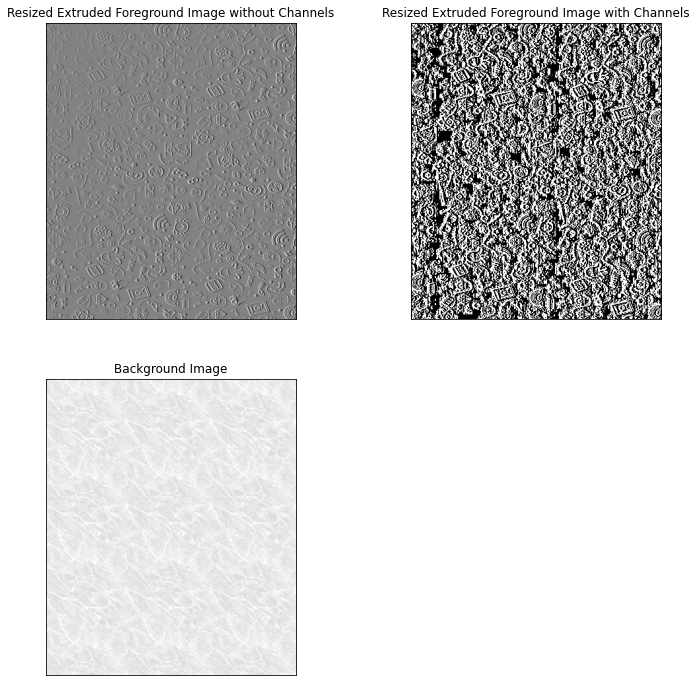

In [34]:
display_all([
  { "img": extruded_fg_img, "title": "Resized Extruded Foreground Image without Channels" },
  { "img": final_fg_img, "title": "Resized Extruded Foreground Image with Channels" },
  { "img": bg_img, "title": "Background Image" },
], figsize=(12,12), column_limit=2)

Save extruded image to disc so it can be read in with alpha channels and original grayscale look in tact. See https://stackoverflow.com/a/63091765

**NOTE:** Inverted grayscale is gray_r, which make extruded areas concave rather than the desired convex appearance

In [35]:
save_img(final_fg_img, fname='bw_extruded_fg_img.png')

In [36]:
save_img(extruded_fg_img, fname='extruded_fg_img.png')

Read the extruded image back in from disc using opencv to prepare for color transferring

In [37]:
final_fg_img = cv2.imread('bw_extruded_fg_img.png')
extruded_fg_img = cv2.imread('extruded_fg_img.png')

In [38]:
if extruded_fg_img.shape == bg_img.shape:
  print("Extruded foreground image shape matches background image shape.")
else:
  print("Extruded foreground image shape doesn't match background image shape.")
  
print(f"|-- Foreground shape: {extruded_fg_img.shape}")
print(f"|-- Background shape: {bg_img.shape}")

Extruded foreground image shape matches background image shape.
|-- Foreground shape: (450, 380, 3)
|-- Background shape: (450, 380, 3)


In [39]:
# help(cv2.Canny)

In [40]:
# Dialate foreground image to emphasize extrusion
# Taking a matrix of size 5 as the kernel
# kernel = np.ones((5, 5), np.uint8)

# The first parameter is the original image,
# kernel is the matrix with which image is
# convolved and third parameter is the number
# of iterations, which will determine how much
# you want to erode/dilate a given image.
# dilated_fg_img = cv2.dilate(extruded_fg_img, kernel, iterations=1)

In [41]:
# canny_fg_img = cv2.Canny(extruded_fg_img, 100, 200)

In [42]:
help(display)

Help on function display in module __main__:

display(img, title='Image', cmap='gray', figsize=(10, 5))



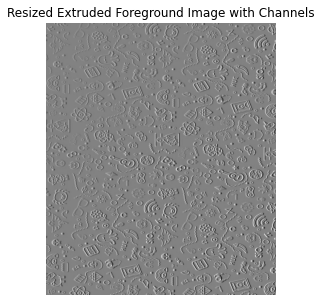

In [43]:
# Display new extruded image with color alpha channels
# Disabling color map (cmap) for proof of concept that the new extruded image is colored
display(
  extruded_fg_img, 
  "Resized Extruded Foreground Image with Channels",
  cmap=None
)

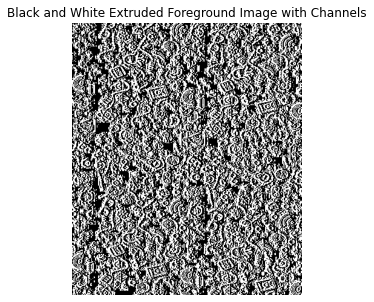

In [44]:
# Display black and white extruded image with color alpha channels
# Disabling color map (cmap) for proof of concept that the new extruded image is colored
display(
  final_fg_img, 
  "Black and White Extruded Foreground Image with Channels",
  cmap=None
)

In [45]:
# Convert black pixels to white
# Get (i, j) positions of all RGB pixels that are black (i.e. [0, 0, 0])
black_pixels = np.where(
    (final_fg_img[:, :, 0] == 0) & 
    (final_fg_img[:, :, 1] == 0) & 
    (final_fg_img[:, :, 2] == 0)
)

# Set those pixels to gray
final_fg_img[black_pixels] = [128, 128, 128]

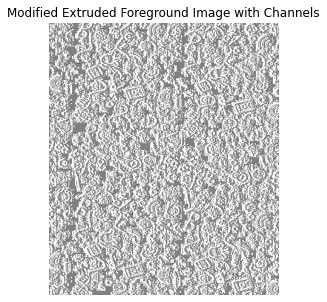

In [46]:
display(
  final_fg_img, 
  "Modified Extruded Foreground Image with Channels",
  cmap=None
)

**Goal:** Apply background image as a skin to the extruded foreground image

In [47]:
help(cv2.addWeighted)

Help on built-in function addWeighted:

addWeighted(...)
    addWeighted(src1, alpha, src2, beta, gamma[, dst[, dtype]]) -> dst
    .   @brief Calculates the weighted sum of two arrays.
    .   
    .   The function addWeighted calculates the weighted sum of two arrays as follows:
    .   \f[\texttt{dst} (I)= \texttt{saturate} ( \texttt{src1} (I)* \texttt{alpha} +  \texttt{src2} (I)* \texttt{beta} +  \texttt{gamma} )\f]
    .   where I is a multi-dimensional index of array elements. In case of multi-channel arrays, each
    .   channel is processed independently.
    .   The function can be replaced with a matrix expression:
    .   @code{.cpp}
    .       dst = src1*alpha + src2*beta + gamma;
    .   @endcode
    .   @note Saturation is not applied when the output array has the depth CV_32S. You may even get
    .   result of an incorrect sign in the case of overflow.
    .   @param src1 first input array.
    .   @param alpha weight of the first array elements.
    .   @param src2 se

Final Blended Image


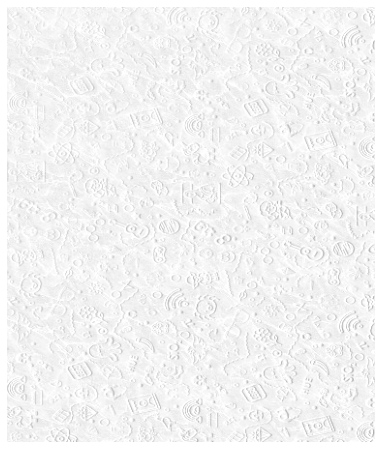

In [48]:
# Use image blending to achieve desired result
fg_weight = 0.55
bg_weight = 0.65
scalar = 20.0 # Scalar added to each sum when blending images
blended_img = cv2.addWeighted(extruded_fg_img, fg_weight, bg_img, bg_weight, scalar)
# blended_img = cv2.addWeighted(bg_img, bg_weight, final_fg_img, fg_weight, scalar)

print("Final Blended Image")
display(blended_img, title=None, cmap=None, figsize=(8,8))

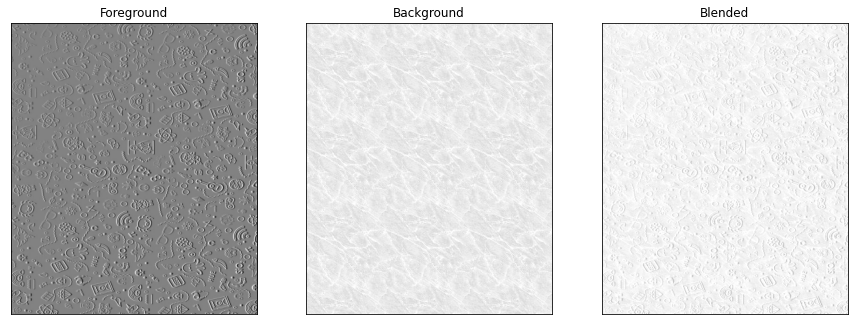

In [49]:
# Display all images for comparison of start to finish
display_all([
  { "img": extruded_fg_img, "title": "Foreground" },
  { "img": bg_img, "title": "Background" },
  { "img": blended_img, "title": "Blended" },
], figsize=(15,15), column_limit=3)

In [50]:
# Save final result to file
save_img(blended_img, fname='blended.png')

The main processing is complete. However, the following sections contain a few experiments that were conducted when determining the best way to blend the extruded foreground image with the selected background image.

## Color Transfer Experiment

In [51]:
# Combine the images with color transfer
# Transfer the color distribution from the source image to the target image
transfer = ct.color_transfer(
  source=extruded_fg_img, 
  target=bg_img,
  clip=True, 
  preserve_paper=True
)

/Users/brett/GitHub/bfx-notebooks/computer-vision/extrusion-blending/color_transfer.py:57: RuntimeWarning: invalid value encountered in float_scalars
  a = (aStdTar / aStdSrc) * a
/Users/brett/GitHub/bfx-notebooks/computer-vision/extrusion-blending/color_transfer.py:58: RuntimeWarning: invalid value encountered in float_scalars
  b = (bStdTar / bStdSrc) * b


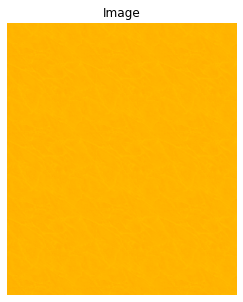

In [52]:
display(transfer)

## Image Dilation Experiment
Experiment with dilating random regions of interest (ROI) in background image to see if dilation achieves the desired extrusion effect.

If the answer is yes, then the path forward will be to post-process the extruded background image to be black and white. Pixes that are white (e.g., value of 1) will be indicators for where in the background image dialation should be applied. Pixels that are black (e.g., value of 0) will be skipped.

In [53]:
# Make a copy of the background image to prevent from making changes to the original
bg_img_copy = bg_img.copy()

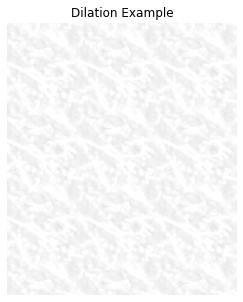

In [54]:
# Taking a matrix of size 5 as the kernel
kernel = np.ones((5, 5), np.uint8)
img_dilation = cv2.dilate(bg_img_copy, kernel, iterations=1)
display(img_dilation, "Dilation Example", cmap=None)

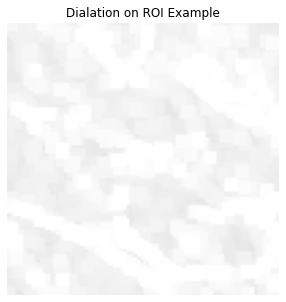

In [55]:
# Dilate only region of interest (ROI)
roi = bg_img[:100, :100, :]
roi[:] = cv2.dilate(roi, kernel) # the [:] is important
display(roi, "Dialation on ROI Example", cmap=None)

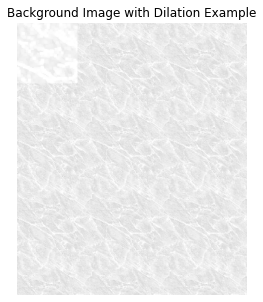

In [56]:
display(bg_img, "Background Image with Dilation Example", cmap=None)

## Other Experiments

In [57]:
# TODO Try approach from https://stackoverflow.com/a/51679078


In [58]:
# TODO Try approach from https://realpython.com/python-opencv-color-spaces/
